In [3]:
!pip install spotipy
!pip install gradio
!pip install opencv-python
!pip install PyQt5
!pip install flask
!pip install tqdm

In [4]:
# 셀 0: 라이브러리 로딩 및 OSTTextDataset 클래스 정의
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import pickle

from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    AdamW
)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

SCENE_CSV_PATH = "blip_video_frames.csv"

# BERT 모델 + LabelEncoder 저장 디렉토리
BERT_OUTPUT_DIR = "./bert_ost_model"
os.makedirs(BERT_OUTPUT_DIR, exist_ok=True)

BATCH_SIZE   = 8
NUM_EPOCHS   = 3
LEARNING_RATE= 2e-5
MAX_LENGTH   = 64

class OSTTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        input_ids      = encoding["input_ids"].squeeze(0)       # (max_length,)
        attention_mask = encoding["attention_mask"].squeeze(0)  # (max_length,)

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": torch.tensor(label, dtype=torch.long)
        }


In [5]:
# 라벨 인코더 생성 및 저장
labels = [
    "10CM - 고장난걸까",
    "김나영 - 일기",
    "김수현 - 청혼",
    "김태래(ZerobaseOne) - 더 바랄게 없죠",
    "부석순 - 자꾸만 웃게돼",
    "소수빈 - Last Chance",
    "최유리 - Promise",
    "크러쉬(Crush) - 미안해 미워해 사랑해",
    "폴캄 - 좋아해요",
    "헤이즈(Heize) - 멈춰줘",
    "홍이삭 - fallin'",
    "dori - 떨림"
]

label_encoder = LabelEncoder()
label_encoder.fit(labels)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

In [6]:
# 셀 1: CSV 불러오기 및 LabelEncoder 준비

df = pd.read_csv(SCENE_CSV_PATH, encoding="utf-8-sig")

print(f"총 샘플 개수: {len(df)}")
print(df[["frame_path", "generated_caption", "label"]].head(3))

scene_texts = df["generated_caption"].tolist()
raw_labels  = df["label"].tolist()

label_encoder = LabelEncoder()
label_encoder.fit(raw_labels)

with open(os.path.join(BERT_OUTPUT_DIR, "label_encoder.pkl"), "wb") as f:
    pickle.dump(label_encoder, f)

labels = label_encoder.transform(raw_labels)
print("고유 라벨 (OST) 개수:", len(label_encoder.classes_))
print("라벨 세트 예시:", label_encoder.classes_)


총 샘플 개수: 1005
                     frame_path             generated_caption         label
0  video_frames/0/frame_000.jpg  김수현이 수트와 타이를 매고 김지원을 바라보는 장면  10CM - 고장난걸까
1  video_frames/0/frame_001.jpg  김수현이 수트와 타이를 매고 김지원을 바라보는 장면  10CM - 고장난걸까
2  video_frames/0/frame_002.jpg  김수현이 수트와 타이를 매고 김지원을 바라보는 장면  10CM - 고장난걸까
고유 라벨 (OST) 개수: 12
라벨 세트 예시: ['10CM - 고장난걸까' 'dori - 떨림' '김나영 - 일기' '김수현 - 청혼'
 '김태래(ZerobaseOne) - 더 바랄게 없죠' '부석순 - 자꾸만 웃게돼' '소수빈 - Last Chance'
 '최유리 - Promise' '크러쉬(Crush) - 미안해 미워해 사랑해' '폴킴 - 좋아해요' '헤이즈(Heize) - 멈춰줘'
 "홍이삭 - fallin'"]


In [7]:
# 셀 2: 학습/검증 분리 및 DataLoader 생성

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-multilingual-cased")

train_texts, val_texts, train_labels, val_labels = train_test_split(
    scene_texts, labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

train_dataset = OSTTextDataset(train_texts, train_labels, tokenizer, max_length=MAX_LENGTH)
val_dataset   = OSTTextDataset(val_texts,   val_labels,   tokenizer, max_length=MAX_LENGTH)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

print(f"학습 샘플 수: {len(train_dataset)}, 검증 샘플 수: {len(val_dataset)}")


학습 샘플 수: 804, 검증 샘플 수: 201


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Epoch 1/5] Train Loss: 1.7251, Acc: 0.5721  |  Val Loss: 0.7740, Acc: 0.8607
[Epoch 2/5] Train Loss: 0.4602, Acc: 0.9378  |  Val Loss: 0.2243, Acc: 0.9751
[Epoch 3/5] Train Loss: 0.1526, Acc: 0.9938  |  Val Loss: 0.0734, Acc: 1.0000
[Epoch 4/5] Train Loss: 0.0652, Acc: 1.0000  |  Val Loss: 0.0403, Acc: 1.0000
[Epoch 5/5] Train Loss: 0.0395, Acc: 1.0000  |  Val Loss: 0.0237, Acc: 1.0000
✅ BERT 학습 완료 및 bert_model_re.pt 저장됨


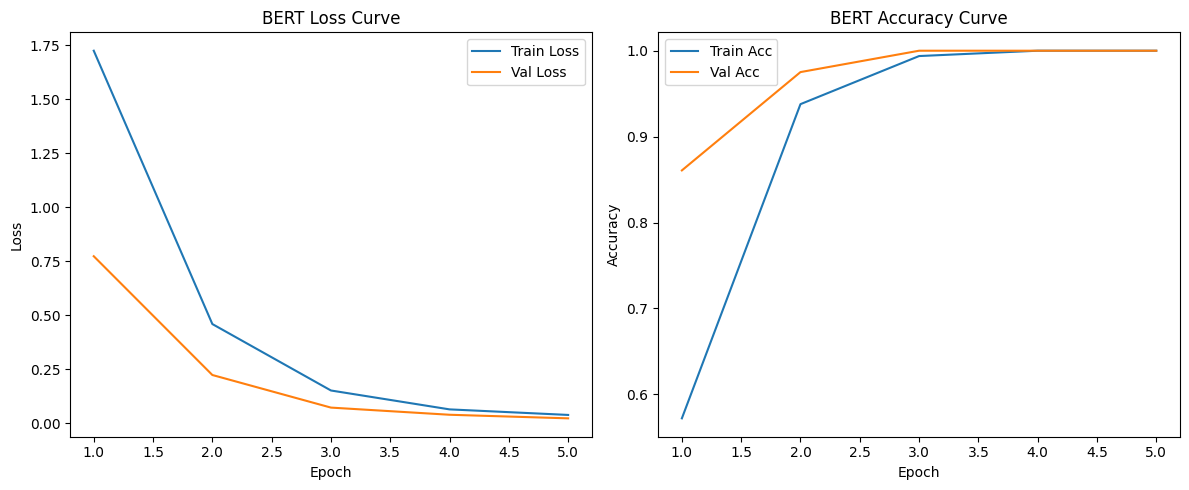

In [12]:
# (1) CSV에서 학습 데이터 로드 (컬럼명: scene_text, label)
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import pickle

# CSV 로드
DF_PATH = "blip_video_frames.csv"
df = pd.read_csv(DF_PATH, encoding="utf-8-sig")

# 레이블 인코더 재생성 (CSV에 있는 모든 라벨 반영)
label_encoder = LabelEncoder()
label_encoder.fit(df['label'].tolist())
# 변경된 인코더 저장
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

num_labels = len(label_encoder.classes_)

# 텍스트와 라벨 리스트 생성
texts = df["generated_caption"].tolist()
labels = label_encoder.transform(df["label"].tolist())

# (2) 학습/검증 분리
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, stratify=labels, random_state=42
)

# (3) Dataset & DataLoader 정의
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer
import torch

def create_dataloaders(tokenizer, batch_size=8, max_length=64):
    class OSTTextDataset(Dataset):
        def __init__(self, texts, labels):
            self.texts = texts
            self.labels = labels
        def __len__(self):
            return len(self.texts)
        def __getitem__(self, idx):
            enc = tokenizer(
                self.texts[idx], truncation=True, padding='max_length',
                max_length=max_length, return_tensors='pt'
            )
            return {
                'input_ids': enc['input_ids'].squeeze(),
                'attention_mask': enc['attention_mask'].squeeze(),
                'labels': torch.tensor(self.labels[idx], dtype=torch.long)
            }

    train_ds = OSTTextDataset(train_texts, train_labels)
    val_ds   = OSTTextDataset(val_texts,   val_labels)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size)
    return train_loader, val_loader

# 토크나이저 초기화
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-multilingual-cased")
train_loader, val_loader = create_dataloaders(tokenizer)

# (4) 모델 초기화
from transformers import DistilBertForSequenceClassification
bert_model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-multilingual-cased", num_labels=num_labels
).to(DEVICE)

# (5) Optimizer 및 Loss 정의
import torch.optim as optim
import torch.nn as nn
optimizer = optim.AdamW(bert_model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

epochs = 5
train_losses, val_losses, train_accs, val_accs = [], [], [], []

# (6) 학습/검증 루프
for epoch in range(1, epochs+1):
    # Training
    bert_model.train()
    running_loss = correct = total = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(DEVICE)
        attn_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)
        outputs = bert_model(input_ids=input_ids, attention_mask=attn_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss/total)
    train_accs.append(correct/total)

    # Validation
    bert_model.eval()
    val_loss = val_correct = val_total = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(DEVICE)
            attn_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)
            outputs = bert_model(input_ids=input_ids, attention_mask=attn_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            val_loss += loss.item() * labels.size(0)
            preds = logits.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss/val_total)
    val_accs.append(val_correct/val_total)

    print(f"[Epoch {epoch}/{epochs}] "
          f"Train Loss: {train_losses[-1]:.4f}, Acc: {train_accs[-1]:.4f}  |  "
          f"Val Loss: {val_losses[-1]:.4f}, Acc: {val_accs[-1]:.4f}")

# (7) 모델 저장
import torch
torch.save(bert_model.state_dict(), "bert_model_re.pt")
print("✅ BERT 학습 완료 및 bert_model_re.pt 저장됨")

# (8) 학습 곡선 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1,len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1,len(val_losses)+1),   val_losses,   label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('BERT Loss Curve')
plt.subplot(1,2,2)
plt.plot(range(1,len(train_accs)+1), train_accs, label='Train Acc')
plt.plot(range(1,len(val_accs)+1),   val_accs,   label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('BERT Accuracy Curve')
plt.tight_layout()
plt.show()

In [1]:
from tqdm import tqdm

def train_epoch(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0.0
    for batch in tqdm(data_loader, desc="Train", leave=False):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    avg_loss = total_loss / len(data_loader)
    return avg_loss

def evaluate_epoch(model, data_loader, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Eval", leave=False):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total if total > 0 else 0.0
    return avg_loss, accuracy